<a href="https://colab.research.google.com/github/Badm0nting/neural-style-transfer/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Import Required Libraries**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time
import functools

# **Step 2: Upload the images and their paths**

In [34]:
from google.colab import files
uploaded = files.upload()

Saving Drake.jpg to Drake.jpg
Saving Monalisa.jpg to Monalisa.jpg


In [52]:
content_path = 'Drake.jpg'
style_path = 'Monalisa.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

# **Step 3: Load Content and Style Images**

Use high-resolution images for better results. Let’s define a function to load and preprocess images:

In [43]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# **Step 4: Load the Pre-trained VGG19 Model**

In [45]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

We'll extract layers used for style and content representation.

In [46]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# **Step 5: Define Functions to Compute Style and Content**

In [47]:
def vgg_layers(layer_names):
    """Creates a VGG model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

# **Step 6: Build StyleContentModel**

In [48]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:len(self.style_layers)],
                                          outputs[len(self.style_layers):])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# **Step 7: Define the Loss Function**

In [49]:
def style_content_loss(outputs, style_targets, content_targets, style_weight=1e-2, content_weight=1e4):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

# **Step 8: Run the Optimization Loop**

In [50]:
@tf.function()
def train_step(image, extractor, style_targets, content_targets, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

# **Step 9: Put It All Together and Train**

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_66']
Received: inputs=Tensor(shape=(1, 512, 338, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_66']
Received: inputs=Tensor(shape=(1, 512, 264, 3))
  warnings.warn(msg)


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed


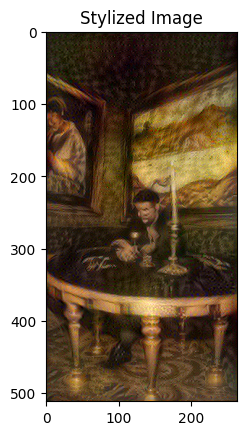

In [51]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=0.02)
epochs = 10
steps_per_epoch = 100

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image, extractor, style_targets, content_targets, opt)
    print(f"Epoch {n+1} completed")

# Display result
imshow(image.read_value(), 'Stylized Image')